<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-первичный-анализ" data-toc-modified-id="Загрузка-данных-и-первичный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и первичный анализ</a></span></li><li><span><a href="#Лемматизация-текста" data-toc-modified-id="Лемматизация-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация текста</a></span></li><li><span><a href="#Выделение-тестовой-выбрки" data-toc-modified-id="Выделение-тестовой-выбрки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выделение тестовой выбрки</a></span></li><li><span><a href="#Вычисление-TF-IDF-и-удаление-стоп-слов" data-toc-modified-id="Вычисление-TF-IDF-и-удаление-стоп-слов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вычисление TF-IDF и удаление стоп слов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import Pipeline

### Загрузка данных и первичный анализ

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Данные выглядят нормально, однако есть дисбаланс классов(только каждый 10-ый комментарий токсичный). Будем с этим что-то делать.

### Лемматизация текста

Функция для очистки текста от знаков препинания и лишних символов.

In [5]:
def clear_text(row):
    sub_text = re.sub(r'[^a-zA-Z ]', ' ', row['text'])
    split_text = sub_text.split()
    return  " ".join(split_text)

Оч крутая штука, которую нашёл на просторах интернета, когда нужно было ускорить лемматизацию.(Одна итерация == 1 секунда) Склеивает тексты в большие тексты, после чего лемматизирует их, а потом обратно разделяет. Как я понял из статейки, то Mystem работает с внешней памятью, поэтому уменьшив количество таких обращений мы невероятно сильно ускорили лемматизацию.(Отрабатывает примерно за 3 минуты == 180 секунд, если считать итерацию за одну секунду, то 160*10^3/180 почти на три порядка буст.
Статья про ускорение лемматизации, откуда взял эту функцию(изменил только одну строчку, чтобы происходила обратная склейка в строки, а не возвращался список списков слов):https://habr.com/ru/post/503420/

In [6]:
def FWordNetLemmatizer(texts):
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 5000)
    res = []
    i = 0
    for txtp in txtpart:
        print("Iter")
        alltexts = ' '.join([txt + ' кот ' for txt in txtp])
        alltexts = nltk.word_tokenize(alltexts)
        words = [mystem.lemmatize(w) for w in alltexts]
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'кот':
                    res.append(" ".join(doc))
                    doc = []
                else:
                    doc.append(txt)
    return res

Подчищаем комментарии.

In [7]:
data['clear_text'] = data.apply(clear_text, axis = 1)

***Проверка на разделитель***

In [8]:
string = data['clear_text'].str.cat(sep = ' ')

In [9]:
string.find(' кот ')

-1

Отлично, мы удостоверились, что русского слова кот нет в комментариях(мы их заранее почистили), а также мы используем короткое слово, являющееся леммой, чтобы было меньше нагрузки и при лемматизации слово не пропало.

***Собственно лемматизация***

In [11]:
texts = list(data['clear_text'])

In [12]:
texts[10]

'Fair use rationale for Image Wonju jpg Thanks for uploading Image Wonju jpg I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use In addition to the boilerplate fair use template you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use Please go to the image description page and edit it to include a fair use rationale If you have uploaded other fair use media consider checking that you have specified the fair use rationale on those pages too You can find a list of image pages you have edited by clicking on the my contributions link it is located at the very top of any Wikipedia page when you are logged in and then selecting Image from the dropdown box Note that any fair use images uploaded after May and lacking such an explanation will be deleted one week after

In [13]:
nltk.download('wordnet')
mystem = WordNetLemmatizer()
lemm_text = FWordNetLemmatizer(texts)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter
Iter


In [14]:
lemm_text[10]

'Fair use rationale for Image Wonju jpg Thanks for uploading Image Wonju jpg I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale a to why it use in Wikipedia article constitutes fair use In addition to the boilerplate fair use template you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use Please go to the image description page and edit it to include a fair use rationale If you have uploaded other fair use medium consider checking that you have specified the fair use rationale on those page too You can find a list of image page you have edited by clicking on the my contribution link it is located at the very top of any Wikipedia page when you are logged in and then selecting Image from the dropdown box Note that any fair use image uploaded after May and lacking such an explanation will be deleted one week after they 

### Выделение тестовой выбрки

In [15]:
features_valid, features_test, target_valid, target_test = train_test_split(lemm_text, data['toxic'], test_size = 0.2, random_state = 12345)

### Вычисление TF-IDF и удаление стоп слов

In [16]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
count_tf_idf.fit(features_valid)
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Привели наши данные к виду, с которым уже можно работать.

## Обучение

### Модель логистической регрессии

In [17]:
score = make_scorer(f1_score, greater_is_better = True)

In [18]:
%%time
best_score = 0

for c in np.logspace(-1,1, 20):
    model = LogisticRegression(C = c, class_weight = 'balanced', random_state=0)
    scores = cross_val_score(model, features_valid, target_valid, scoring = score, cv = 3)
    final_score = scores.mean()
    print(c, final_score)
    if final_score > best_score:
        best_score = final_score
        best_model = model


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.1 0.7029597798568061


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.12742749857031338 0.7076093722154151


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.16237767391887217 0.7133777240554359


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.20691380811147897 0.717897738362446


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.26366508987303583 0.7234307065370348


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.33598182862837817 0.7278028902668519


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.42813323987193935 0.7327539718517361


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5455594781168519 0.7371053117787892


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6951927961775606 0.7425189390029354


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8858667904100825 0.7448209193377685


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.1288378916846888 0.7484151038214507


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.438449888287663 0.7521917809185098


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.8329807108324356 0.7560262865385323


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2.3357214690901213 0.7574415289173473


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2.9763514416313175 0.7594432678763149


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3.79269019073225 0.7610433174375432


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4.832930238571752 0.7625250912748714


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6.158482110660261 0.7632114296771859


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


7.847599703514611 0.7631510736653674


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10.0 0.7625360173532072
CPU times: user 8min 27s, sys: 6min 24s, total: 14min 51s
Wall time: 14min 55s


***Вывод***

Модель логистической регрессии уже даёт нам нужный результат, при использовании гиперпараметра class_weight = 'balanced', однако нужно протестировать и другие модели.(balanced помогает нам, так как у нас соотношение нетоксичных комментариев к токсичным 9 к 1). Также дефолтный коэффициент регуляризации нам не подходит, его также подобрали.

### Модель дерева решений

In [19]:
%%time
for depth in range(6,20):
    model = DecisionTreeClassifier(random_state=0, max_depth = depth, class_weight = 'balanced')
    scores = cross_val_score(model, features_valid, target_valid, scoring = score, cv = 3)
    final_score = scores.mean()
    print(final_score)
    if final_score > best_score:
        best_score = final_score
        best_model = model

0.49327105863460513
0.5064325958835081
0.5322181003026537
0.533350976033703
0.3696974437024885
0.5468992875794675
0.47026159892171177
0.38094131489625477
0.47616035037031246
0.4796424157079386
0.5700960250557249
0.5751789397847156
0.5859711710919949
0.593442741471319
CPU times: user 12min 58s, sys: 0 ns, total: 12min 58s
Wall time: 13min 9s


***Вывод***

Увы, но модель дерева решений намного хуже, чем модель логистической регрессии. Возможно при очень большой глубине дерева мы получим что-то сравнимое с регрессией, но время оучения уже сейчас оставляет желать лучшего, а что будет дальше - сложно представить.

### Модель случайного леса

In [20]:
%%time
for est in range(7,12):
    model = RandomForestClassifier(n_estimators = est, random_state=0, class_weight = 'balanced')
    scores = cross_val_score(model, features_valid, target_valid, scoring = score, cv = 3)
    final_score = scores.mean()
    print(final_score)
    if final_score > best_score:
        best_score = final_score
        best_model = model

0.6118872621262752
0.5685085334669602
0.6109065741826253
0.5740142104177085
0.6113743510136328
CPU times: user 18min 18s, sys: 0 ns, total: 18min 18s
Wall time: 18min 30s


***Вывод***

Моддель случайного леса немного лучше модели дерева решений, но обучается ещё дольше, а в сревнении с регрессией результаты совсем плохи.

### Проверка на тестовой выборке

In [21]:
best_model.fit(features_valid, target_valid)
predicted = best_model.predict(features_test)
test_score = f1_score(predicted, target_test)
print(test_score)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7635125549723365


***Вывод***

На тестовой выборке наши результаты даже лучше, чем на кросс-валидации. Это может быть связанно с тем, что мы обучили модель на всей выборке, а так как мы использовали cv = 3, то по сути увеличили выборку на 50%.

## Выводы

0.9697902158495092


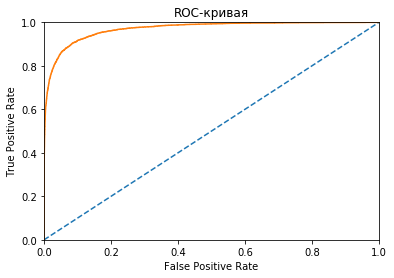

In [22]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

***Вывод***

Мы получили требуемое качество модели, хотя и использовали лишь простейшие модели, так как время обучения очень быстро растёт с усложнением модели. Также наша модель имеет "хороший", выпуклый график ROC-кривой. 

***P.S. Вот доказательство, что балансировка классов нам помогает***

In [23]:
model = LogisticRegression(random_state=0)
model.fit(features_valid, target_valid)
predicted = model.predict(features_test)
test_score = f1_score(predicted, target_test)
print(test_score)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7338799850913157
